# Processing LST rasters and cloud data from bulk download

After the bulk download application (https://dds.cr.usgs.gov/bulk) is used to download many scenes from EarthExplorer, they will be located in the default folder that was created by the bulk download application. For me, that file location is: '/home/tclim/bda' and a subdirectory was created with the name of the bulk download I gave: 'Bulk Order atlanta summers 2019 - 2022'). In this directoy, are a bunch of tar compressed directories that contain the rasters of interest, for example:

- LC08_CU_024014_20210525_20210602_02_QA_PIXEL.TIF
- LC08_CU_024014_20210525_20210602_02_ST_B10.TIF

Among other layers that were part of the two bundles downloaded. This notebook will show how to go through each date (scene) for which data was obtained, process the rasters into degrees C, handle missing data, and then take means across the 14 scenes.


In [17]:
import rasterio
import pandas as pd
import numpy as np
import os
import tarfile

import matplotlib.pyplot as plt

%matplotlib inline

In [42]:
tars = os.listdir('/home/tclim/bda/Bulk Order atlanta summers 2019 - 2022/Landsat 4-9 C2 U.S. ARD/')
tars[0]

'LE07_CU_024014_20210526_20210625_02_QA.tar'

In [47]:
# for loop to extract all files into a new directory (where the notebook is located called extracted_files)

for t in tars:
    cur_tar = tarfile.open('/home/tclim/bda/Bulk Order atlanta summers 2019 - 2022/Landsat 4-9 C2 U.S. ARD/' + t)
    cur_tar.extractall('./extracted_files') # specify which folder to extract to
    cur_tar.close()

## Make a list of all the unique scenes

Meaning of the file names in product manual for ARD: https://d9-wret.s3.us-west-2.amazonaws.com/assets/palladium/production/s3fs-public/atoms/files/LSDS-1619_Landsat8-C2-L2-ScienceProductGuide-v2.pdf

See page 10.

`LXSS_LLLL_PPPRRR_YYYYMMDD_yyyymmdd_CX_TX`

- L = Landsat
- X = Sensor (C = OLS/TIRS; E = ?)
- LLLL = Processing correction level (“L2SP” if SR and ST are generated or “L2SR” if ST could not be generated)
- PPP = Path
- RRR = Row
- YYYY = Year of acquisition
- MM = Month of acquisition
- DD = Day of acquisition
- yyyy = year of level 2 processing
- mm = month of level 2 processing
- dd = day of level 2 processing
- CX = Collection number
- TX = Collection category (“RT” = Real-Time; “T1” = Tier 1; “T2” = Tier 2)


In [48]:
# list of all the extracted files... note: some of these appear not to have the B10 data for surface temp
os.listdir('./extracted_files/')

['LE07_CU_024014_20210729_20210828_02_ST_QA.TIF',
 'LC08_CU_024014_20210705_20210716_02_ST_TRAD.TIF',
 'LE07_CU_024014_20210517_20210616_02_QA_PIXEL.TIF',
 'LC08_CU_024014_20210610_20210625_02_ST_EMSD.TIF',
 'LE07_CU_024014_20210814_20210913_02_QA_LINEAGE.TIF',
 'LC08_CU_024014_20210525_20210602_02_ST_TRAD.TIF',
 'LC08_CU_024014_20210907_20210919_02_QA_PIXEL.TIF',
 'LE07_CU_024014_20210814_20210913_02.json',
 'LE07_CU_024014_20210805_20210904_02_QA_LINEAGE.TIF',
 'LE07_CU_024014_20210704_20210803_02_ST_EMIS.TIF',
 'LE07_CU_024014_20210814_20210913_02_QA_PIXEL.TIF',
 'LE07_CU_024014_20210805_20210904_02_ST_EMSD.TIF',
 'LE07_CU_024014_20210729_20210828_02_ST_CDIST.TIF',
 'LC08_CU_024014_20210705_20210716_02_ST_EMSD.TIF',
 'LC08_CU_024014_20210914_20210928_02_ST_URAD.TIF',
 'LE07_CU_024014_20210729_20210828_02_ST_EMSD.TIF',
 'LC08_CU_024014_20210914_20210928_02_QA_PIXEL.TIF',
 'LE07_CU_024014_20210526_20210625_02_QA_LINEAGE.TIF',
 'LE07_CU_024014_20210805_20210904_02_ST_EMIS.TIF',
 'LC08_

In [57]:
# unique acquisition dates

ac_dates = []

for f in os.listdir('./extracted_files/'):
    ac_dates.append(f.split('_')[3])

In [58]:
ac_dates = list(set(ac_dates))

In [59]:
ac_dates

['20210610',
 '20210814',
 '20210805',
 '20210705',
 '20210517',
 '20210704',
 '20210728',
 '20210526',
 '20210907',
 '20210627',
 '20210813',
 '20210525',
 '20210914',
 '20210729']

# For each unique date, process the raw LST with cloud data

In [61]:
def proc_lst(b10_file_loc, qa_pixel_file_loc, output_file_loc):
    '''
    Takes raw LST input from Analysis Ready Data (C2) Earth Explorer and
    the QA_Pixel file, both as rasters (TIF) and outputs a raster file
    for land surface temperature in Celsius, with nodata for missing or
    cloud-influenced pixels
    '''
    # Read in input files
    b10_file = rasterio.open(b10_file_loc) 
    clouds_file = rasterio.open(qa_pixel_file_loc)
    
    # load in data, starting from index 1 (band)
    b10 =  b10_file.read(1)    # This is a numpy array
    clouds =  clouds_file.read(1)

    #reclassify all values in the clouds raster that are not "clear" (21824) to 0:
    clouds_bin = np.where(clouds != 21824, 0, clouds)
    clouds_bin = np.where(clouds_bin == 21824, 1, clouds_bin)
    
    #multiply the two arrays together
    b10_clouds = np.multiply(b10,clouds_bin)
    b10_clouds = np.where(b10_clouds == 0, np.nan, b10_clouds)
    
    # convert with USGS multiplicative/additive factors and from K to C
    lst_c = (b10_clouds*0.00341802 + 149) - 273.1
    
    
    # Edit metadata like a dictionary in python to write to raster file:
    out_meta = b10_file.meta.copy()
    out_meta.update({'driver':'GTiff',
                 'width':b10_file.shape[1],
                 'height':b10_file.shape[0],
                 'count':1,
                 'dtype':'float64',
                 'crs':b10_file.crs, 
                 'transform':b10_file.transform,
                 'nodata':np.nan})
    
    with rasterio.open(output_file_loc, 'w', **out_meta) as dst:
        dst.write_band(1, lst_c.astype(rasterio.float64))
    

In [86]:
dir_loc = './extracted_files/'

for d in ac_dates:
    # make a list of files matching an acquisition date
    date_match_fnams = [x for x in os.listdir('./extracted_files/') if x.split('_')[3] == d] 
    
    # check that neither b10 or qa_pixel length is zero (this would happen if there is no b10 or qa_pixel raster available)
    if len([x for x in date_match_fnams if x.split('_')[-1] == 'B10.TIF']) * len([x for x in date_match_fnams if x.split('_')[-1] == 'PIXEL.TIF']) == 0:
        pass
    
    else:
        # get the name of the file with b10
        b10_fnam = [x for x in date_match_fnams if x.split('_')[-1] == 'B10.TIF'][0]

        # get the name of the file with cloud data
        cloud_fnam = [x for x in date_match_fnams if x.split('_')[-1] == 'PIXEL.TIF'][0]
    
        # use file names in function to produce processed raster
        proc_lst(dir_loc + b10_fnam, dir_loc + cloud_fnam, './processed_lsts/lst_' + d + '_C.TIF')

# Average Across Rasters

In [5]:
lst_C_files = os.listdir('./processed_lsts/')
lst_C_files

['lst_20210907_C.TIF',
 'lst_20210525_C.TIF',
 'lst_20210914_C.TIF',
 'lst_20210610_C.TIF',
 'lst_20210705_C.TIF',
 'lst_20210728_C.TIF',
 'lst_20210813_C.TIF']

## Option 1: Absolute Degrees Celsius

In [6]:
# load each file as a value in a dictionary

my_dict = {}

for i in range(len(lst_C_files)):
    c_file = rasterio.open('./processed_lsts/' + lst_C_files[i])
    my_dict[i] = c_file.read(1)

In [13]:
# convert the dictionary to a 3D array
test = np.array(list(my_dict.values()))

In [26]:
# summarize across the arrays
final = np.nanmean(test, axis = 0)

/home/tclim/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: Mean of empty slice
  


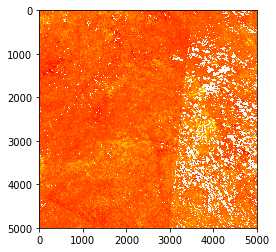

In [28]:
 plt.imshow(final, cmap = 'hot')

### Write out to raster

In [29]:
# Edit metadata like a dictionary in python:

out_meta = c_file.meta.copy()
out_meta.update({'driver':'GTiff',
                 'width':c_file.shape[1],
                 'height':c_file.shape[0],
                 'count':1,
                 'dtype':'float64',
                 'crs':c_file.crs, 
                 'transform':c_file.transform,
                 'nodata':np.nan})
out_meta


# then: save the index in format Geotiff using rasterio:

with rasterio.open(os.path.join("./aggregated_lst/", 'mean_C.tif'), 'w', **out_meta) as dst:
    dst.write_band(1, final.astype(rasterio.float64))

## Option 2: Difference from Mean Temperature in Each Scene